In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import eng_to_ipa as p
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Load the data

In [2]:
df = pd.read_csv("avgRatings_annotated.csv")
df.drop(df.columns[7:22], axis = 1, inplace = True)
df.head()

,name,age,polarity,name_type,rating.mean_age,rating.mean_gender,rating.mean_valence,gender
0,Adelaide,old,NaN,real,-0.617647,45.727273,NaN,female
1,Adelina,NaN,bad,real,NaN,47.771429,31.621622,female
2,Alasdair,young,NaN,real,18.709677,-35.657143,NaN,male
3,Alastor,old,NaN,madeup,13.812500,-38.833333,NaN,male
4,Alecto,old,NaN,madeup,3.593750,-35.722222,NaN,female


In [3]:
for i in range(len(df["name"])):
    if df["polarity"].loc[i] == "good":
        df["polarity"].loc[i] = 1
    elif df["polarity"].loc[i] == "bad" or df["polarity"].loc[i] == "ambiguous":
        df["polarity"].loc[i] = 0
        
for i in range(len(df["name"])):
    if df["gender"].loc[i] == "female":
        df["gender"].loc[i] = 1
    elif df["gender"].loc[i] == "male":
        df["gender"].loc[i] = 0
        
for i in range(len(df["name"])):
    if df["age"].loc[i] == "young":
        df["age"].loc[i] = 1
    elif df["age"].loc[i] == "old":
        df["age"].loc[i] = 0

C:\Users\gk200\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Vectorize

### Letter Features

In [4]:
def count_vector(word):
    alphabet_string = string.ascii_lowercase
    alphabet_list = list(alphabet_string)
    
    vector = []
    for i in range(len(alphabet_list)):
        vector.append(word.lower().count(alphabet_list[i]))
        
    return vector

df["letter_vec"] = pd.NaT

vector_list = []
for i in range(len(df["name"])):
    cv = count_vector(df.loc[i]["name"])
    vector_list.append(cv)
    
varray = np.array(vector_list, dtype=int)

for i in range(len(df["name"])):
    df["letter_vec"].loc[i] = varray[i]

In [5]:
feature_names_lf = list(string.ascii_lowercase)

### Phonological Features

In [8]:
ipa_temp = []

for name in df["name"].values:
    nipa = p.convert(name)
    if nipa[-1] == "*":
        ipa_temp.append("NA")
    else:
        ipa_temp.append(nipa)
  
print("NA value count: ", len([ipa_temp[i] for i in range(len(ipa_temp)) if ipa_temp[i] == "NA"]))
#print(ipa_temp)
df["IPA"] = ipa_temp

NA value count:  53


In [9]:
na_names_tr = pd.read_csv("na_names.csv")

for i in range(len(df["name"])):
    for j in range(len(na_names_tr["name"])):
        if df["name"].loc[i] == na_names_tr["name"][j]:
            df["IPA"].loc[i] = na_names_tr["IPA"][j]

In [10]:
feature_dict = {"Obstruents": ["t","d","s","z","ɬ","ɮ","θ","ð","c","ɟ","ç","ʝ"],
                "Fricatives": ["ɸ","β","f","v","θ","ð","s","z","ʃ","ʒ","ʂ","ʐ","ç","ʝ","x","ɣ","χ","ʁ","ħ","ʕ","h","ɦ"],
                "Lateral Fricatives": ["ɬ","ɮ"],
                "Plosives": ["p","b","t","d","ʈ","ɖ","c","ɟ","k","g","q","ɢ","ʔ"],
                "Nasals": ["m","ɱ","n","ɳ","ɲ","ŋ","ɴ"],
                "Approximants": ["ʋ","ɹ","ɻ","j","ɰ"],
                "Lateral Approximants": ["l","ɭ","ʎ","ʟ"],
                "Alveolars": ["t","d","n","r","ɾ","s","z","ɬ","ɮ","ɹ","l"],
                "Glottals": ["ʔ","h","ɦ"],
                "Dentals": ["θ","ð"],
                "Bilabials": ["p","b","m","ʙ","ɸ","β"],
                "Sonorants": ["m","ɱ","n","ɳ","ɲ","ŋ","ɴ","l","ʎ","r","ɹ","ʀ"],
                "Velars": ["k","ɡ","ŋ","x","ɣ","ɰ","ʟ"],
                "Voiced": ["b","m","ʙ","β","ɱ","ⱱ","v","ʋ","ð","d","n","r","ɾ","z","ɮ","ɹ","l","ʒ","ɖ","ɳ","ɽ","ʐ","ɻ","ɭ","ɟ","ɲ","ʝ","j","ʎ","ɡ","ŋ","ɣ","ɰ","ʟ","ɢ","ɴ","ʀ","ʁ","ʕ","ɦ"],
                "Voiceless": ["p","ɸ","f","θ","t","s","ɬ","ʃ","ʈ","ʂ","c","ç","k","x","q","χ","ħ","ʔ","h"],
                "High": ["i","y","ɪ","ʏ","ɨ","ʉ","ʊ","ɯ","u"],
                "Mid": ["e","ø","ɘ","ɵ","ɤ","o","ə","ɛ","œ","ɜ","ɞ","ʌ","ɔ"],
                "Low": ["æ","ɐ","a","ɶ","ɑ","ɒ"],
                "Front": ["i","y","ɪ","ʏ","e","ø","ɛ","œ","æ","a","ɶ"],
                "Central": ["ɨ","ʉ","ɘ","ɵ","ə","ɜ","ɞ","ɐ"],
                "Back": ["ɯ","u","ʊ","ɤ","o","ʌ","ɔ","ɑ","ɒ"],
                "Rounded": ["y","ʏ","ø","œ","ɶ","ʉ","ɵ","ɞ","u","o","ɔ","ɒ"],
                "Unrounded": ["i","e","ɪ","ɛ","a","ɨ","ɘ","ɜ","ɯ","ɤ","ʌ","ɑ"]}

In [11]:
feature_names_pf = list(feature_dict.keys())

In [12]:
def get_phonological_features(word_ipa, feature_dict):
    word_pv = np.zeros((1, len(feature_dict.keys())), dtype=int)
    word_pvdf = pd.DataFrame(word_pv, columns=list(feature_dict.keys()))
    for i in range(len(word_ipa)):
        for key in list(feature_dict.keys()):
            if word_ipa[i] in feature_dict[key]:
                word_pvdf[key][0] += 1
    return word_pvdf.iloc[0]

df["phonological_vec"] = pd.NaT

vector_list = []
for i in range(len(df["IPA"])):
    phv = np.array(get_phonological_features(df.loc[i]["IPA"], feature_dict), dtype=int)
    vector_list.append(phv)
    
varray = np.array(vector_list, dtype=int)
varray

for i in range(len(df["name"])):
    df["phonological_vec"].loc[i] = varray[i]

# Training

In [13]:
def train_RFC(input_df, feature_col, attribute_col):
    
    #cross-validation and model instantiations
    loo = LeaveOneOut()
    forest = RandomForestClassifier(random_state=7)
    
    #parameter grid and GridSearchCV (shuffle is false so random state is not actually needed but is there just in case)
    param_grid = {"n_estimators" : [25, 50, 75, 100], "max_depth" : [5, 8, 15, 25]}
    gs_rf = GridSearchCV(forest, param_grid, scoring="neg_mean_absolute_error", cv=KFold(3, random_state=7))
    
    
    #getting the data to be split
    xlist = [vector for vector in input_df[feature_col]]
    xarray = np.array(xlist, dtype=int)    

    X = xarray
    y = np.array(input_df[attribute_col],dtype=int)   
    
    #getting the names and their types of ease of use later on
    names = input_df["name"]
    types = input_df["name_type"]
    

    #list for the prediction of each name's rating
    predictions = []
    #feature importances list to store each (LOOCV) fold's feature importances
    importances = []
    
    #do the cross validation split (test is going to be only one name and train is going to be every other name but that)
    for train_index, test_index in loo.split(X):
        x_train = X[train_index]
        x_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
    
        #list with names in the test set and their type, again for easier use later
        test_names = list(names.iloc[test_index])
        test_name_types = list(types.iloc[test_index])
    
        #fit the model on this fold's training set
        model = gs_rf.fit(x_train,y_train)
        #predict the score for the test set (name)
        prediction = gs_rf.predict(x_test)
        #get the predicted probabilities as well
        prob_pred = gs_rf.predict_proba(x_test)

        #append the name, its type, its feature representation, its actual rating, 
        #and its predicted rating and prediction probability into the predictions list
        for i in range(len(x_test)):
            predictions.append((test_names[i],test_name_types[i],x_test[i],y_test[i],prediction[i], prob_pred[i]))
            
        #append the current (LOOCV) fold's best model's (according to GridSearch) feature importances into the importances list   
        importances.append(model.best_estimator_.feature_importances_)
        
    return predictions, importances

In [73]:
def train_LRC(input_df, feature_col, attribute_col):
    
    #cross-validation and model instantiations
    loo = LeaveOneOut()
    logreg = LogisticRegression(max_iter=3000)
    
    param_grid = {"C" : [0.001, 0.01, 0.1, 1, 10, 100]}
    gs_logreg = GridSearchCV(logreg, param_grid, cv=KFold(3, random_state=7))
    
    #getting the data to be split
    xlist = [vector for vector in input_df[feature_col]]
    xarray = np.array(xlist, dtype=int)    

    X = xarray
    y = np.array(input_df[attribute_col],dtype=int)   
    
    #getting the names and their types of ease of use later on
    names = input_df["name"]
    types = input_df["name_type"]
    

    #list for the prediction of each name's rating
    predictions = []
    #feature importances list to store each fold's feature importances
    importances = []
    
    #do the cross validation split (test is going to be only one name and train is going to be every other name but that)
    for train_index, test_index in loo.split(X):
        x_train = X[train_index]
        x_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
    
        #list with names in the test set and their type, again for easier use later
        test_names = list(names.iloc[test_index])
        test_name_types = list(types.iloc[test_index])
    
        #fit the model on this fold's training set
        model = gs_logreg.fit(x_train,y_train)
        #predict the score for the test set (name)
        prediction = gs_logreg.predict(x_test)
        prob_pred = gs_logreg.predict_proba(x_test)

        #append the name, its type, its feature representation, its actual rating, and its predicted rating into the predictions list
        for i in range(len(x_test)):
            predictions.append((test_names[i],test_name_types[i],x_test[i],y_test[i],prediction[i], prob_pred[i]))
            
        weights = model.best_estimator_.coef_[0]
            
        #append the current fold's best model's (according to GridSearch) feature importances into the importances list   
        importances.append(pow(math.e, weights))
        
    return predictions, importances

In [18]:
def metrics_and_eval(predictions):
    
    
    cm = confusion_matrix([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    precision = precision_score([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))], average = None)
    recall= recall_score([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))], average = None)
    accuracy = accuracy_score([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    
    r2 = r2_score([predictions[i][3] for i in range(len(predictions))], [predictions[i][5][predictions[i][3]] for i in range(len(predictions))])
    mae = mean_absolute_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][5][predictions[i][3]] for i in range(len(predictions))])
    mse = mean_squared_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][5][predictions[i][3]] for i in range(len(predictions))])
    med_ae = median_absolute_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][5][predictions[i][3]] for i in range(len(predictions))])
    
    #-------------------------------------------------------------------------------------
    
    real_names_y, talking_names_y, madeup_names_y = [],[],[]
    real_names_pred, talking_names_pred, madeup_names_pred = [],[],[]
    
    aes={"real":[], "talking":[], "madeup":[]}
    
    for i in range(len(predictions)):
        if predictions[i][1] == "real":
            real_names_y.append(predictions[i][3])
            real_names_pred.append(predictions[i][4])
            aes["real"].append(abs(predictions[i][3] - predictions[i][5]))
        if predictions[i][1] == "talking":
            talking_names_y.append(predictions[i][3])
            talking_names_pred.append(predictions[i][4])
            aes["talking"].append(abs(predictions[i][3] - predictions[i][5]))
        if predictions[i][1] == "madeup":
            madeup_names_y.append(predictions[i][3])
            madeup_names_pred.append(predictions[i][4])
            aes["madeup"].append(abs(predictions[i][3] - predictions[i][5]))
            
    accuracy_per_nametype = {"real": accuracy_score(real_names_y, real_names_pred),
                             "talking": accuracy_score(talking_names_y, talking_names_pred),
                             "madeup": accuracy_score(talking_names_y, talking_names_pred)}
    
    avg_mae_per_nametype = {"real": np.mean(aes["real"]),
                            "talking": np.mean(aes["talking"]) ,
                            "madeup": np.mean(aes["madeup"])}
        
    
    return accuracy, precision, recall, cm, accuracy_per_nametype, avg_mae_per_nametype, r2, mae, mse, med_ae

In [99]:
def map_prob(x,cra,crb,wrc,wrd):
    return wrc + ((wrd - wrc) / (crb - cra)) * (x - cra)

## Polarity

In [16]:
pol_df = df.loc[df['polarity'].notnull(), ["name",  "name_type", "polarity", "rating.mean_valence", "letter_vec", "phonological_vec"]]
pol_df.reset_index(drop=True, inplace=True)

### Random Forest

In [19]:
RFLF_pol = train_RFC(pol_df, "letter_vec", "polarity")
RFLFPOL_results = metrics_and_eval(RFLF_pol[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [22]:
print("Accuracy: ", RFLFPOL_results[0], "Precision: ", RFLFPOL_results[1], "Recall: ", RFLFPOL_results[2], 
      "Confusion matrix: ", RFLFPOL_results[3], "Accuracy per nametype: ", RFLFPOL_results[4], "\n", 
      "Avg MAE per nametype:", RFLFPOL_results[5], "R2 score:", RFLFPOL_results[6], "MAE:", RFLFPOL_results[7], 
      "MSE:", RFLFPOL_results[8], "Median AE:", RFLFPOL_results[9], sep="\n")

Accuracy: 
0.5714285714285714
Precision: 
[0.52173913 0.6       ]
Recall: 
[0.42857143 0.68571429]
Confusion matrix: 
[[12 16]
 [11 24]]
Accuracy per nametype: 
{'real': 0.7, 'talking': 0.6, 'madeup': 0.6}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
0.13895263565422955
MAE:
0.4318904260468508
MSE:
0.2126042874927829
Median AE:
0.4011872972530989


In [21]:
RFPF_pol = train_RFC(pol_df, "phonological_vec", "polarity")
RFPFPOL_results = metrics_and_eval(RFPF_pol[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [23]:
print("Accuracy: ", RFPFPOL_results[0], "Precision: ", RFPFPOL_results[1], "Recall: ", RFPFPOL_results[2], 
      "Confusion matrix: ", RFPFPOL_results[3], "Accuracy per nametype: ", RFPFPOL_results[4], "\n",
      "Avg MAE per nametype:", RFPFPOL_results[5], "R2 score:", RFPFPOL_results[6], "MAE:", RFPFPOL_results[7], 
      "MSE:", RFPFPOL_results[8], "Median AE:", RFPFPOL_results[9], sep="\n")

Accuracy: 
0.6031746031746031
Precision: 
[0.55555556 0.63888889]
Recall: 
[0.53571429 0.65714286]
Confusion matrix: 
[[15 13]
 [12 23]]
Accuracy per nametype: 
{'real': 0.55, 'talking': 0.7, 'madeup': 0.7}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
-0.07457990732246333
MAE:
0.4638098100106413
MSE:
0.26532837217838606
Median AE:
0.4315757162514129


In [25]:
RFCLFPOL_pred = pd.DataFrame(RFLF_pol[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction", "Pred Probability"])
RFCLFPOL_pred["Features"] = ["Letter" for i in range(len(RFLF_pol[0]))]

RFCPFPOL_pred = pd.DataFrame(RFPF_pol[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction",  "Pred Probability"])
RFCPFPOL_pred["Features"] = ["Phonological" for i in range(len(RFPF_pol[0]))]

RFCPOL_pred = RFCLFPOL_pred.append(RFCPFPOL_pred)

<ipython-input-26-6eee74cac6a4>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


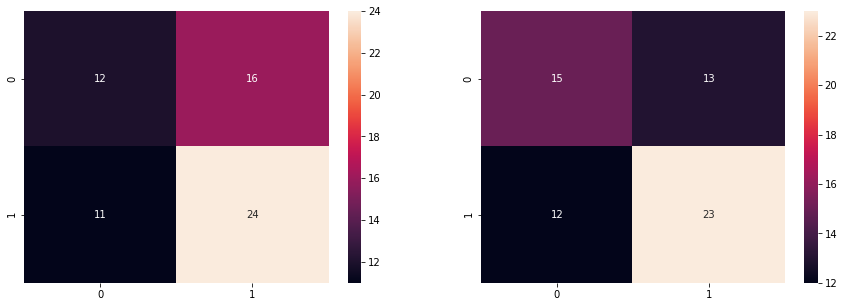

In [26]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.heatmap(RFLFPOL_results[3], annot=True, ax=ax[0])
sns.heatmap(RFPFPOL_results[3], annot=True, ax=ax[1])
fig.show()

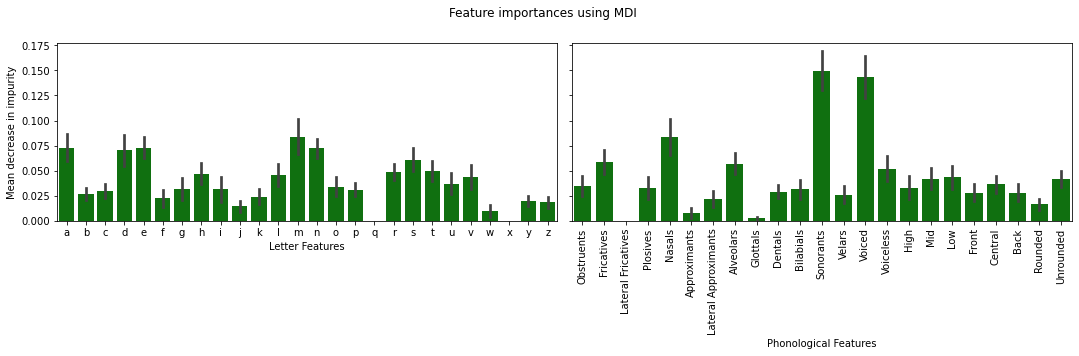

In [28]:
importances_lf = pd.DataFrame(data=RFLF_pol[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=RFPF_pol[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances using MDI")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Mean decrease in impurity")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Logistic Regression

In [74]:
LRLF_pol = train_LRC(pol_df, "letter_vec", "polarity")
LRLFPOL_results = metrics_and_eval(LRLF_pol[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [75]:
print("Accuracy: ", LRLFPOL_results[0], "Precision: ", LRLFPOL_results[1], "Recall: ", LRLFPOL_results[2], 
      "Confusion matrix: ", LRLFPOL_results[3], "Accuracy per nametype: ", LRLFPOL_results[4], "\n", 
      "Avg MAE per nametype:", LRLFPOL_results[5], "R2 score:", LRLFPOL_results[6], "MAE:", LRLFPOL_results[7], 
      "MSE:", LRLFPOL_results[8], "Median AE:", LRLFPOL_results[9], sep="\n")

Accuracy: 
0.5555555555555556
Precision: 
[0.5 0.6]
Recall: 
[0.5 0.6]
Confusion matrix: 
[[14 14]
 [14 21]]
Accuracy per nametype: 
{'real': 0.7, 'talking': 0.5, 'madeup': 0.5}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
-0.3520647253237372
MAE:
0.4573460783968499
MSE:
0.33384314205524385
Median AE:
0.41345503300690645


In [76]:
LRPF_pol = train_LRC(pol_df, "phonological_vec", "polarity")
LRPFPOL_results = metrics_and_eval(LRPF_pol[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [77]:
print("Accuracy: ", LRPFPOL_results[0], "Precision: ", LRPFPOL_results[1], "Recall: ", LRPFPOL_results[2], 
      "Confusion matrix: ", LRPFPOL_results[3], "Accuracy per nametype: ", LRPFPOL_results[4], "\n", 
      "Avg MAE per nametype:", LRPFPOL_results[5], "R2 score:", LRPFPOL_results[6], "MAE:", LRPFPOL_results[7], 
      "MSE:", LRPFPOL_results[8], "Median AE:", LRPFPOL_results[9], sep="\n")

Accuracy: 
0.49206349206349204
Precision: 
[0.42857143 0.54285714]
Recall: 
[0.42857143 0.54285714]
Confusion matrix: 
[[12 16]
 [16 19]]
Accuracy per nametype: 
{'real': 0.45, 'talking': 0.7, 'madeup': 0.7}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
-0.43225204865429445
MAE:
0.4622930755315421
MSE:
0.3536424811492086
Median AE:
0.3865369499843173


In [78]:
LRCLFPOL_pred = pd.DataFrame(LRLF_pol[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction", "Pred Probability"])
LRCLFPOL_pred["Features"] = ["Letter" for i in range(len(LRLF_pol[0]))]

LRCPFPOL_pred = pd.DataFrame(LRPF_pol[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction",  "Pred Probability"])
LRCPFPOL_pred["Features"] = ["Phonological" for i in range(len(LRPF_pol[0]))]

LRCPOL_pred = LRCLFPOL_pred.append(LRCPFPOL_pred)

<ipython-input-79-464e44ca25cd>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


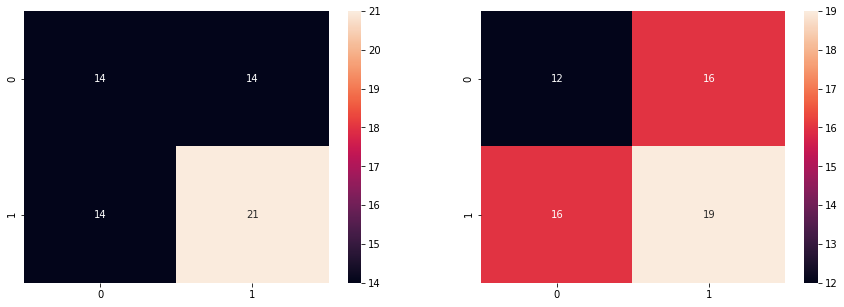

In [79]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.heatmap(LRLFPOL_results[3], annot=True, ax=ax[0])
sns.heatmap(LRPFPOL_results[3], annot=True, ax=ax[1])
fig.show()

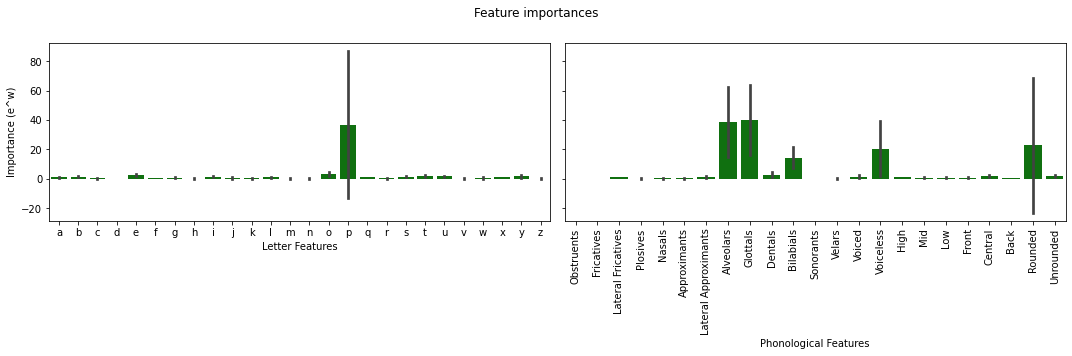

In [80]:
importances_lf = pd.DataFrame(data=LRLF_pol[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=LRPF_pol[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Importance (e^w)")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Gender

In [37]:
gen_df = df.loc[df['gender'].notnull(), ["name", "name_type","gender", "rating.mean_gender", "letter_vec", "phonological_vec"]]
gen_df.reset_index(drop=True, inplace=True)

### Random Forest

In [38]:
RFLF_gen = train_RFC(gen_df, "letter_vec", "gender")
RFLFGEN_results = metrics_and_eval(RFLF_gen[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [39]:
print("Accuracy: ", RFLFGEN_results[0], "Precision: ", RFLFGEN_results[1], "Recall: ", RFLFGEN_results[2], 
      "Confusion matrix: ", RFLFGEN_results[3], "Accuracy per nametype: ", RFLFGEN_results[4], "\n", 
      "Avg MAE per nametype:", RFLFGEN_results[5], "R2 score:", RFLFGEN_results[6], "MAE:", RFLFGEN_results[7], 
      "MSE:", RFLFGEN_results[8], "Median AE:", RFLFGEN_results[9], sep="\n")

Accuracy: 
0.6201117318435754
Precision: 
[0.6091954  0.63043478]
Recall: 
[0.6091954  0.63043478]
Confusion matrix: 
[[53 34]
 [34 58]]
Accuracy per nametype: 
{'real': 0.5862068965517241, 'talking': 0.6557377049180327, 'madeup': 0.6557377049180327}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
-0.03796633670653149
MAE:
0.4810404278678444
MSE:
0.25928911578911645
Median AE:
0.49715311851917887


In [40]:
RFPF_gen = train_RFC(gen_df, "phonological_vec", "gender")
RFPFGEN_results = metrics_and_eval(RFPF_gen[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [42]:
print("Accuracy: ", RFPFGEN_results[0], "Precision: ", RFPFGEN_results[1], "Recall: ", RFPFGEN_results[2], 
      "Confusion matrix: ", RFPFGEN_results[3], "Accuracy per nametype: ", RFPFGEN_results[4], "\n", 
      "Avg MAE per nametype:", RFPFGEN_results[5], "R2 score:", RFPFGEN_results[6], "MAE:", RFPFGEN_results[7], 
      "MSE:", RFPFGEN_results[8], "Median AE:", RFPFGEN_results[9], sep="\n")

Accuracy: 
0.5363128491620112
Precision: 
[0.52325581 0.5483871 ]
Recall: 
[0.51724138 0.55434783]
Confusion matrix: 
[[45 42]
 [41 51]]
Accuracy per nametype: 
{'real': 0.5689655172413793, 'talking': 0.4918032786885246, 'madeup': 0.4918032786885246}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
-0.09446810356152668
MAE:
0.49067997987552925
MSE:
0.27340353612266977
Median AE:
0.48369245716164844


In [43]:
RFCLFGEN_pred = pd.DataFrame(RFLF_gen[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction", "Pred Probability"])
RFCLFGEN_pred["Features"] = ["Letter" for i in range(len(RFLF_gen[0]))]

RFCPFGEN_pred = pd.DataFrame(RFPF_gen[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction",  "Pred Probability"])
RFCPFGEN_pred["Features"] = ["Phonological" for i in range(len(RFPF_gen[0]))]

RFCGEN_pred = RFCLFGEN_pred.append(RFCPFGEN_pred)

<ipython-input-44-343f7b12ed70>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


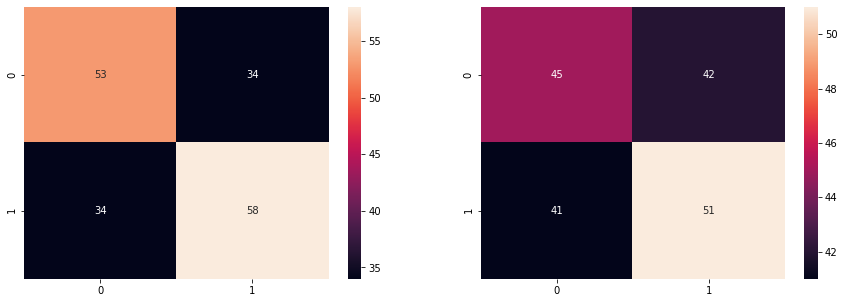

In [44]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.heatmap(RFLFGEN_results[3], annot=True, ax=ax[0])
sns.heatmap(RFPFGEN_results[3], annot=True, ax=ax[1])
fig.show()

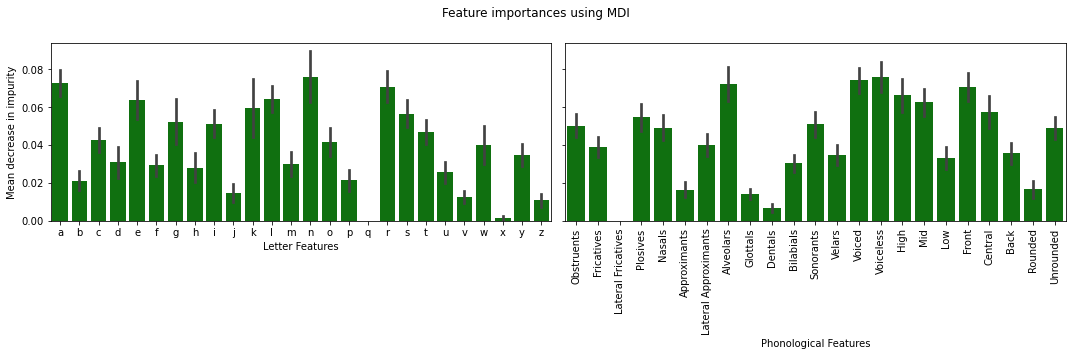

In [45]:
importances_lf = pd.DataFrame(data=RFLF_gen[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=RFPF_gen[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances using MDI")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Mean decrease in impurity")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Logistic Regression

In [81]:
LRLF_gen = train_LRC(gen_df, "letter_vec", "gender")
LRLFGEN_results = metrics_and_eval(LRLF_gen[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [82]:
print("Accuracy: ", LRLFGEN_results[0], "Precision: ", LRLFGEN_results[1], "Recall: ", LRLFGEN_results[2], 
      "Confusion matrix: ", LRLFGEN_results[3], "Accuracy per nametype: ", LRLFGEN_results[4], "\n", 
      "Avg MAE per nametype:", LRLFGEN_results[5], "R2 score:", LRLFGEN_results[6], "MAE:", LRLFGEN_results[7], 
      "MSE:", LRLFGEN_results[8], "Median AE:", LRLFGEN_results[9], sep="\n")

Accuracy: 
0.5977653631284916
Precision: 
[0.59259259 0.60204082]
Recall: 
[0.55172414 0.64130435]
Confusion matrix: 
[[48 39]
 [33 59]]
Accuracy per nametype: 
{'real': 0.6379310344827587, 'talking': 0.5409836065573771, 'madeup': 0.5409836065573771}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
-0.18048243939414976
MAE:
0.47872642263006937
MSE:
0.29489034190289865
Median AE:
0.474931347683643


In [83]:
LRPF_gen = train_LRC(gen_df, "phonological_vec", "gender")
LRPFGEN_results = metrics_and_eval(LRPF_gen[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [84]:
print("Accuracy: ", LRPFGEN_results[0], "Precision: ", LRPFGEN_results[1], "Recall: ", LRPFGEN_results[2], 
      "Confusion matrix: ", LRPFGEN_results[3], "Accuracy per nametype: ", LRPFGEN_results[4], "\n", 
      "Avg MAE per nametype:", LRPFGEN_results[5], "R2 score:", LRPFGEN_results[6], "MAE:", LRPFGEN_results[7], 
      "MSE:", LRPFGEN_results[8], "Median AE:", LRPFGEN_results[9], sep="\n")

Accuracy: 
0.5642458100558659
Precision: 
[0.55696203 0.57      ]
Recall: 
[0.50574713 0.61956522]
Confusion matrix: 
[[44 43]
 [35 57]]
Accuracy per nametype: 
{'real': 0.5517241379310345, 'talking': 0.5901639344262295, 'madeup': 0.5901639344262295}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
0.034109105122247185
MAE:
0.4862070725082474
MSE:
0.2412843145532766
Median AE:
0.49475597676996863


In [85]:
LRCLFGEN_pred = pd.DataFrame(LRLF_gen[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction", "Pred Probability"])
LRCLFGEN_pred["Features"] = ["Letter" for i in range(len(LRLF_gen[0]))]

LRCPFGEN_pred = pd.DataFrame(LRPF_gen[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction",  "Pred Probability"])
LRCPFGEN_pred["Features"] = ["Phonological" for i in range(len(LRPF_gen[0]))]

LRCGEN_pred = LRCLFGEN_pred.append(LRCPFGEN_pred)

<ipython-input-86-3ab24d463f08>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


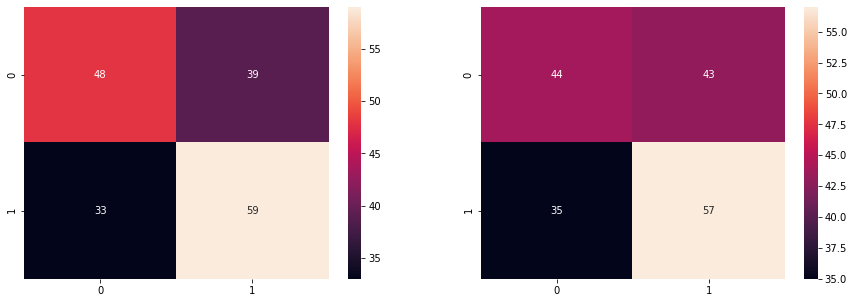

In [86]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.heatmap(LRLFGEN_results[3], annot=True, ax=ax[0])
sns.heatmap(LRPFGEN_results[3], annot=True, ax=ax[1])
fig.show()

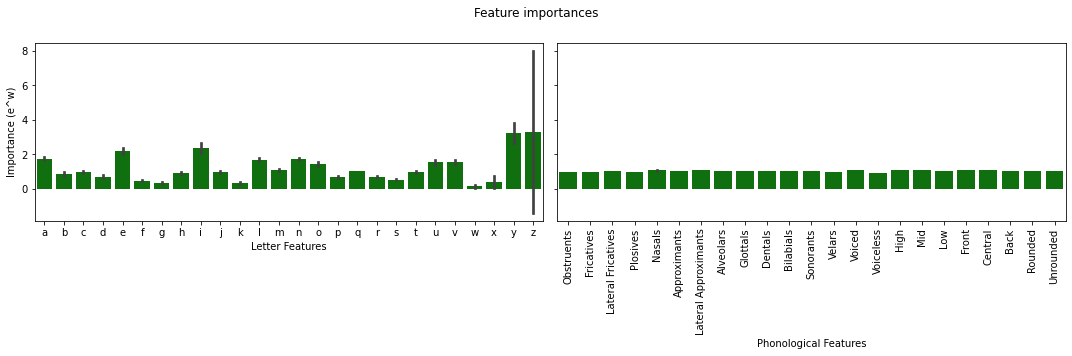

In [87]:
importances_lf = pd.DataFrame(data=LRLF_gen[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=LRPF_gen[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Importance (e^w)")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Age

In [53]:
age_df = df.loc[df['age'].notnull(), ["name", "name_type", "age", "rating.mean_age", "letter_vec", "phonological_vec"]]
age_df.reset_index(drop=True, inplace=True)

### Random Forest

In [54]:
RFLF_age = train_RFC(age_df, "letter_vec", "age")
RFLFAGE_results = metrics_and_eval(RFLF_age[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [55]:
print("Accuracy: ", RFLFAGE_results[0], "Precision: ", RFLFAGE_results[1], "Recall: ", RFLFAGE_results[2], 
      "Confusion matrix: ", RFLFAGE_results[3], "Accuracy per nametype: ", RFLFAGE_results[4], "\n", 
      "Avg MAE per nametype:", RFLFAGE_results[5], "R2 score:", RFLFAGE_results[6], "MAE:", RFLFAGE_results[7], 
      "MSE:", RFLFAGE_results[8], "Median AE:", RFLFAGE_results[9], sep="\n")

Accuracy: 
0.4957983193277311
Precision: 
[0.48888889 0.5       ]
Recall: 
[0.37288136 0.61666667]
Confusion matrix: 
[[22 37]
 [23 37]]
Accuracy per nametype: 
{'real': 0.5, 'talking': 0.4878048780487805, 'madeup': 0.4878048780487805}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
0.017966984320339496
MAE:
0.48082917742851095
MSE:
0.2454909169907491
Median AE:
0.4686237530816776


In [61]:
RFPF_age = train_RFC(age_df, "phonological_vec", "age")
RFPFAGE_results = metrics_and_eval(RFPF_age[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [62]:
print("Accuracy: ", RFPFAGE_results[0], "Precision: ", RFPFAGE_results[1], "Recall: ", RFPFAGE_results[2], 
      "Confusion matrix: ", RFPFAGE_results[3], "Accuracy per nametype: ", RFPFAGE_results[4], "\n", 
      "Avg MAE per nametype:", RFPFAGE_results[5], "R2 score:", RFPFAGE_results[6], "MAE:", RFPFAGE_results[7], 
      "MSE:", RFPFAGE_results[8], "Median AE:", RFPFAGE_results[9], sep="\n")

Accuracy: 
0.42016806722689076
Precision: 
[0.41071429 0.42857143]
Recall: 
[0.38983051 0.45      ]
Confusion matrix: 
[[23 36]
 [33 27]]
Accuracy per nametype: 
{'real': 0.45, 'talking': 0.43902439024390244, 'madeup': 0.43902439024390244}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
-0.017798462020930383
MAE:
0.4840205002736858
MSE:
0.25443164716856814
Median AE:
0.48679634857895726


In [63]:
RFCLFAGE_pred = pd.DataFrame(RFLF_age[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction", "Pred Probability"])
RFCLFAGE_pred["Features"] = ["Letter" for i in range(len(RFLF_age[0]))]

RFCPFAGE_pred = pd.DataFrame(RFPF_age[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction",  "Pred Probability"])
RFCPFAGE_pred["Features"] = ["Phonological" for i in range(len(RFPF_age[0]))]

RFCAGE_pred = RFCLFAGE_pred.append(RFCPFAGE_pred)

<ipython-input-64-0bb8adf64a3b>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


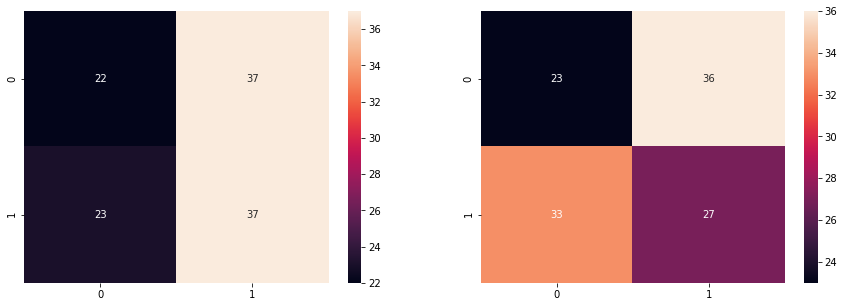

In [64]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.heatmap(RFLFAGE_results[3], annot=True, ax=ax[0])
sns.heatmap(RFPFAGE_results[3], annot=True, ax=ax[1])
fig.show()

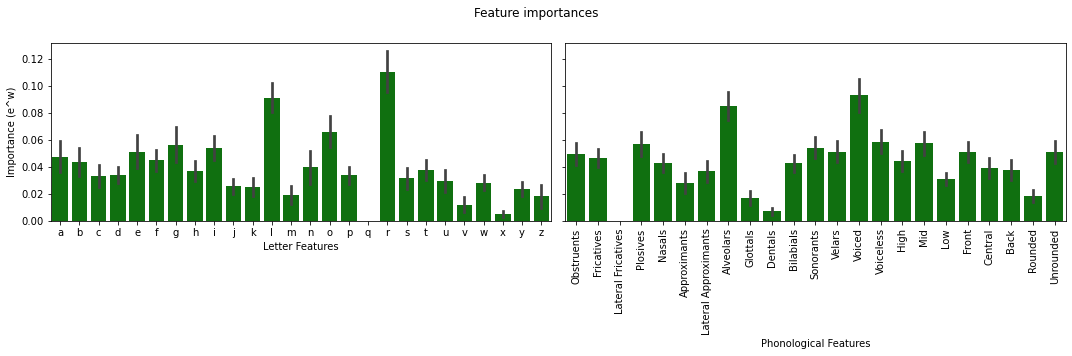

In [65]:
importances_lf = pd.DataFrame(data=RFLF_age[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=RFPF_age[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Importance (e^w)")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Logistic Regression

In [88]:
LRLF_age = train_LRC(age_df, "letter_vec", "age")
LRLFAGE_results = metrics_and_eval(LRLF_age[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [89]:
print("Accuracy: ", LRLFAGE_results[0], "Precision: ", LRLFAGE_results[1], "Recall: ", LRLFAGE_results[2], 
      "Confusion matrix: ", LRLFAGE_results[3], "Accuracy per nametype: ", LRLFAGE_results[4], "\n", 
      "Avg MAE per nametype:", LRLFAGE_results[5], "R2 score:", LRLFAGE_results[6], "MAE:", LRLFAGE_results[7], 
      "MSE:", LRLFAGE_results[8], "Median AE:", LRLFAGE_results[9], sep="\n")

Accuracy: 
0.5126050420168067
Precision: 
[0.50943396 0.51515152]
Recall: 
[0.45762712 0.56666667]
Confusion matrix: 
[[27 32]
 [26 34]]
Accuracy per nametype: 
{'real': 0.5, 'talking': 0.5121951219512195, 'madeup': 0.5121951219512195}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
-0.1844494139374313
MAE:
0.4856975568967427
MSE:
0.2960914430717115
Median AE:
0.4729863792782698


In [90]:
LRPF_age = train_LRC(age_df, "phonological_vec", "age")
LRPFAGE_results = metrics_and_eval(LRPF_age[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [91]:
print("Accuracy: ", LRPFAGE_results[0], "Precision: ", LRPFAGE_results[1], "Recall: ", LRPFAGE_results[2], 
      "Confusion matrix: ", LRPFAGE_results[3], "Accuracy per nametype: ", LRPFAGE_results[4], "\n", 
      "Avg MAE per nametype:", LRPFAGE_results[5], "R2 score:", LRPFAGE_results[6], "MAE:", LRPFAGE_results[7], 
      "MSE:", LRPFAGE_results[8], "Median AE:", LRPFAGE_results[9], sep="\n")

Accuracy: 
0.48739495798319327
Precision: 
[0.47916667 0.49295775]
Recall: 
[0.38983051 0.58333333]
Confusion matrix: 
[[23 36]
 [25 35]]
Accuracy per nametype: 
{'real': 0.5, 'talking': 0.43902439024390244, 'madeup': 0.43902439024390244}


Avg MAE per nametype:
{'real': 0.5, 'talking': 0.5, 'madeup': 0.5}
R2 score:
0.013846739805015273
MAE:
0.4918740285922218
MSE:
0.2465209053802871
Median AE:
0.4925663277790723


In [92]:
LRCLFAGE_pred = pd.DataFrame(LRLF_age[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction", "Pred Probability"])
LRCLFAGE_pred["Features"] = ["Letter" for i in range(len(LRLF_age[0]))]

LRCPFAGE_pred = pd.DataFrame(LRPF_age[0], columns=["Name", "Name Type", "Feature Rep", "Author Intent", "Prediction",  "Pred Probability"])
LRCPFAGE_pred["Features"] = ["Phonological" for i in range(len(LRPF_age[0]))]

LRCAGE_pred = LRCLFAGE_pred.append(LRCPFAGE_pred)

<ipython-input-93-522fcf914225>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


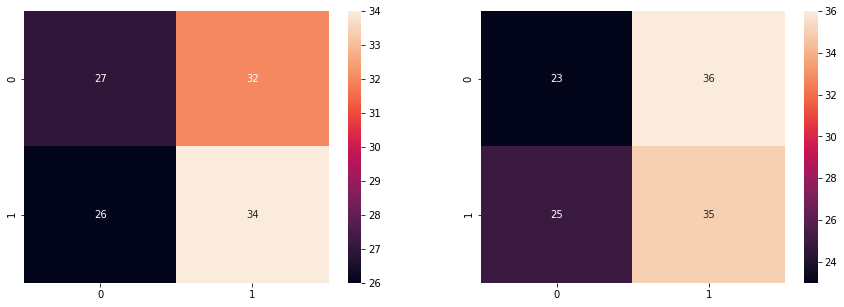

In [93]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.heatmap(LRLFAGE_results[3], annot=True, ax=ax[0])
sns.heatmap(LRPFAGE_results[3], annot=True, ax=ax[1])
fig.show()

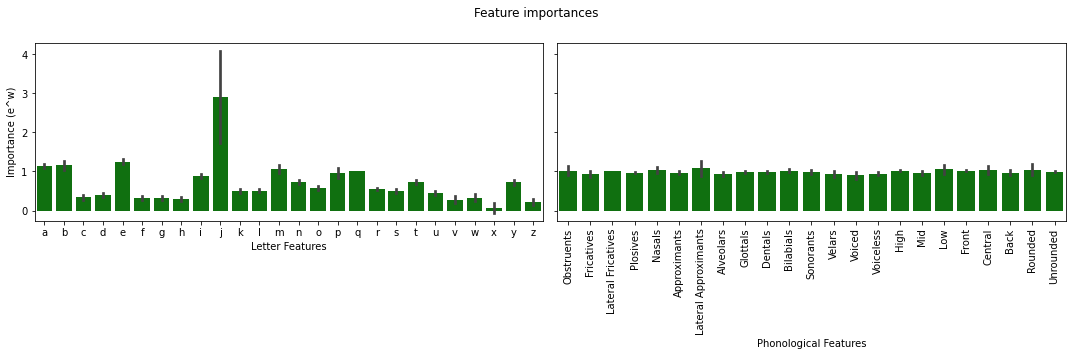

In [94]:
importances_lf = pd.DataFrame(data=LRLF_age[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=LRPF_age[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Importance (e^w)")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)